In [ ]:
#|hide
#from mirzoo.core import *

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PLSR local models
Trained by lab & analyte

In [ ]:
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="tab10")

from mirzoo.data.transform import SNV, TakeDerivative, DropSpectralRegion, CO2_REGION
from mirzoo.data.loading import get_spectra, get_wetchem

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_rows', 500)

In [ ]:
# Data loading
fname = './files/RT_STD_allMIRspectra_raw.csv'
orgs, smp_ids, X_names, X, df_sp = get_spectra(fname)

fname = './files/RT_wetchem_soildata.csv'
y, y_napt, df_wc = get_wetchem(fname)

In [ ]:
# By org, analyte, seed, n_cpts, r2_valid, r2_test, r2_napt
results = {'org': [], 'analyte': [], 'seed': [], 'n_cpt': [],
           'r2_test': []}

test_size = 0.2
n_seeds = 20
for org in tqdm(np.unique(orgs)):
    for analyte in ['clay_perc', 'pH_H20', 'carbon_tot_perc', 'potassium_cmolkg']:
        for seed in range(n_seeds):
            mask = orgs == org
            y, _, _  = get_wetchem(fname, analyte=analyte)
            X_train, X_test, y_train, y_test = train_test_split(X[mask, :][:len(y),:], y,
                                                                test_size=test_size,
                                                                random_state=seed)

            param_grid = {'model__n_components': range(1,10)}
            pipe = Pipeline([('snv', SNV()),
                             ('derivative', TakeDerivative(window_length=11, polyorder=1)),
                             ('dropper', DropSpectralRegion(X_names, region=CO2_REGION)),
                             ('model', PLSRegression(n_components=cpt))])
            search = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=8)
            y_train = np.log(y_train) if analyte == 'carbon_tot_perc' else y_train
            search.fit(X_train, y_train)

            y_test = np.log(y_test) if analyte == 'carbon_tot_perc' else y_test
            r2_test = r2_score(search.best_estimator_.predict(X_test), y_test)
            results['org'].append(org)
            results['analyte'].append(analyte)
            results['seed'].append(seed)
            results['n_cpt'].append(search.best_params_['model__n_components'])
            results['r2_test'].append(r2_test)

df_results = pd.DataFrame(results)

100%|█████████████████████████████████████████████████████████████| 16/16 [01:23<00:00,  5.21s/it]


In [ ]:
def summarize(df, analyte):
    print(60*'*')
    print(f'Perfs by Lab. for: {analyte}')
    print(60*'*')
    print(df.query(f'analyte=="{analyte}"').groupby('org')\
              .agg({'r2_test': ['min', 'mean', 'max', 'std']})\
              .sort_values(by=('r2_test', 'mean'), ascending=False), '\n')

In [ ]:
for analyte in ['clay_perc', 'pH_H20', 'carbon_tot_perc', 'potassium_cmolkg']:
    summarize(df_results, analyte)

************************************************************
Perfs by Lab. for: clay_perc
************************************************************
                  r2_test                              
                      min      mean       max       std
org                                                    
UWisc_fine       0.178093  0.656488  0.936018  0.260874
ETH_alpha_1     -0.508152  0.544455  0.924210  0.377353
OSU             -0.707323  0.541936  0.922453  0.423804
LandCare        -0.488250  0.504200  0.901344  0.427323
IAEA_jun2022    -1.273246  0.503280  0.877676  0.486752
Agrocares       -0.704468  0.472487  0.890464  0.432991
ETH_vertex      -1.573527  0.457934  0.931692  0.603351
ETH_alpha_2     -0.760354  0.456645  0.922692  0.541053
KSSL            -1.558192  0.449765  0.904910  0.595472
Argonne         -1.012999  0.449282  0.932352  0.537677
Woodwell_vertex -1.377850  0.439295  0.926852  0.564282
Woodwell_alpha  -0.892172  0.435716  0.921947  0.483144
MSU      

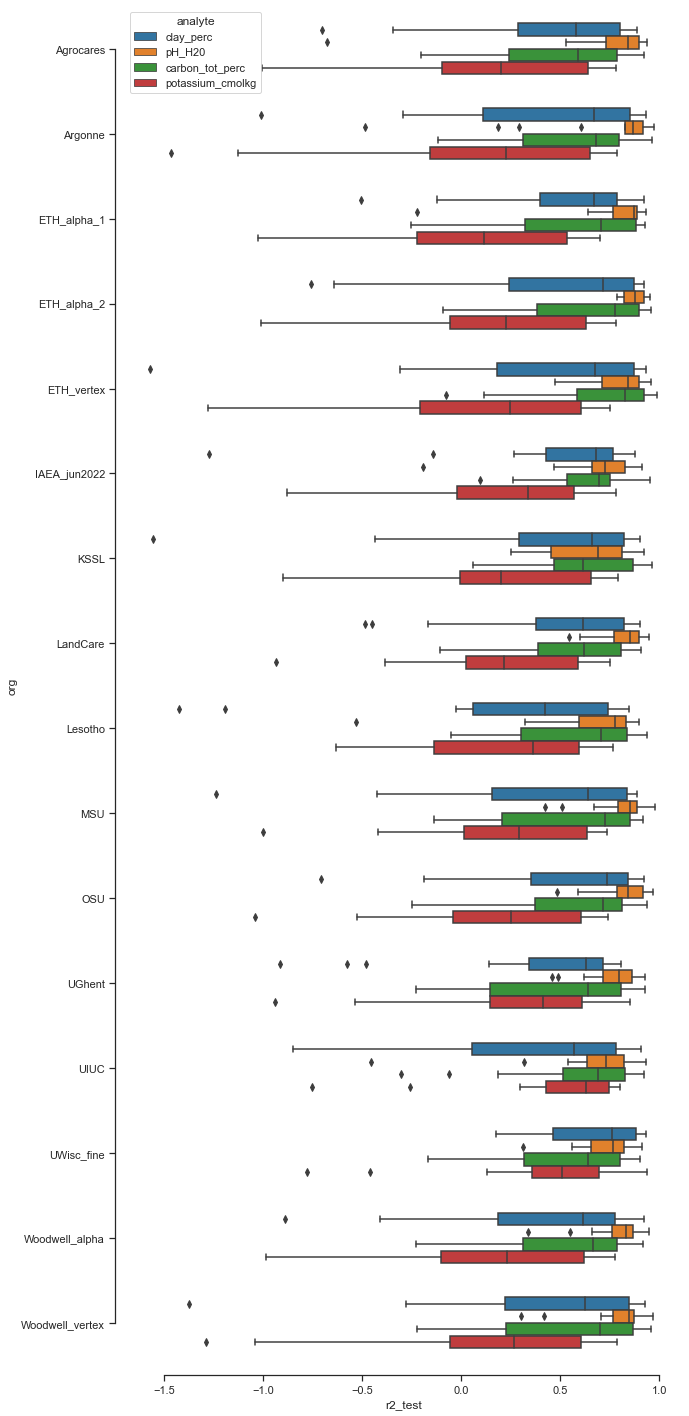

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(10,25))
sns.boxplot(x='r2_test', y='org',hue='analyte',
            width=0.6, dodge=True, ax=ax, data=df_results)

sns.despine(offset=10, trim=True)